In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [3]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = image_dataset_from_directory(train_dir, shuffle=True, batch_size = BATCH_SIZE, image_size = IMG_SIZE)

68608000/68606236 [==============================] - 18s 0us/step
Found 2000 files belonging to 2 classes.


In [4]:
validation_dataset = image_dataset_from_directory(validation_dir, shuffle=True, batch_size = BATCH_SIZE, image_size = IMG_SIZE)

Found 1000 files belonging to 2 classes.


In [5]:
class_names = train_dataset.class_names

In [6]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 26
Number of test batches: 6


In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [8]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [10]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False,
                                              weights='imagenet')

9412608/9406464 [==============================] - 2s 0us/step


In [11]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [12]:
base_model.trainable = False

In [13]:
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [17]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [19]:
inputs = tf.keras.Input(shape=(160,160,3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [20]:
base_learning_rate = 0.0001
model.compile(optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss = tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy']
             )

In [21]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_1 (TensorFlo [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)             

In [22]:
len(model.trainable_variables)

2

In [23]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

26/26 [==============================] - 2s 93ms/step - loss: 0.8768 - accuracy: 0.4876


In [24]:
print("Initial loss: {:.2f}".format(loss0))
print("Initial Accuracy: {:.2f}".format(accuracy0))

Initial loss: 0.88
Initial Accuracy: 0.49


In [25]:
history = model.fit(train_dataset,
                   epochs=initial_epochs,
                   validation_data=validation_dataset)

Epoch 1/10
63/63 [==============================] - 9s 143ms/step - loss: 0.8406 - accuracy: 0.4960 - val_loss: 0.6138 - val_accuracy: 0.6250
Epoch 2/10
63/63 [==============================] - 3s 51ms/step - loss: 0.6215 - accuracy: 0.6345 - val_loss: 0.4461 - val_accuracy: 0.7574
Epoch 3/10
63/63 [==============================] - 3s 51ms/step - loss: 0.4841 - accuracy: 0.7370 - val_loss: 0.3438 - val_accuracy: 0.8453
Epoch 4/10
63/63 [==============================] - 3s 51ms/step - loss: 0.4034 - accuracy: 0.8040 - val_loss: 0.2797 - val_accuracy: 0.8886
Epoch 5/10
63/63 [==============================] - 3s 51ms/step - loss: 0.3415 - accuracy: 0.8495 - val_loss: 0.2244 - val_accuracy: 0.9208
Epoch 6/10
63/63 [==============================] - 3s 51ms/step - loss: 0.2973 - accuracy: 0.8645 - val_loss: 0.1983 - val_accuracy: 0.9332
Epoch 7/10
63/63 [==============================] - 3s 50ms/step - loss: 0.2756 - accuracy: 0.8785 - val_loss: 0.1720 - val_accuracy: 0.9443
Epoch 8/10
6

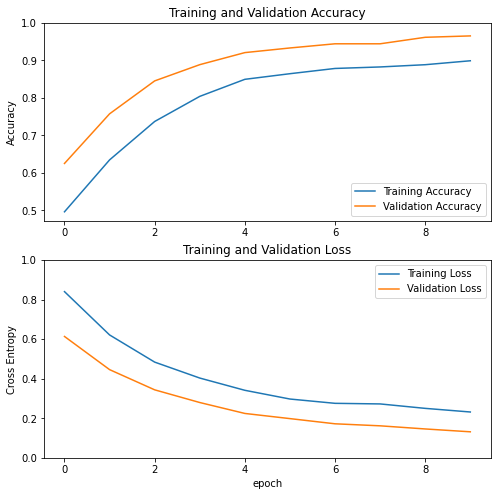

In [26]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [27]:
base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  155


In [28]:
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

In [29]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
             optimizer = tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
             metrics=['accuracy'])

In [30]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 160, 160, 3)       0         
_________________________________________________________________
tf_op_layer_RealDiv_1 (Tenso [(None, 160, 160, 3)]     0         
_________________________________________________________________
tf_op_layer_Sub_1 (TensorFlo [(None, 160, 160, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)             

In [31]:
len(model.trainable_variables)

58

In [32]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                        epochs = total_epochs,
                        initial_epoch = history.epoch[-1],
                        validation_data = validation_dataset)

Epoch 10/20
63/63 [==============================] - 4s 64ms/step - loss: 0.1770 - accuracy: 0.9245 - val_loss: 0.0832 - val_accuracy: 0.9765
Epoch 11/20
63/63 [==============================] - 3s 53ms/step - loss: 0.1258 - accuracy: 0.9505 - val_loss: 0.0552 - val_accuracy: 0.9777
Epoch 12/20
63/63 [==============================] - 3s 53ms/step - loss: 0.1128 - accuracy: 0.9570 - val_loss: 0.0528 - val_accuracy: 0.9814
Epoch 13/20
63/63 [==============================] - 3s 53ms/step - loss: 0.1044 - accuracy: 0.9590 - val_loss: 0.0539 - val_accuracy: 0.9790
Epoch 14/20
63/63 [==============================] - 3s 53ms/step - loss: 0.1040 - accuracy: 0.9525 - val_loss: 0.0417 - val_accuracy: 0.9851
Epoch 15/20
63/63 [==============================] - 3s 53ms/step - loss: 0.0817 - accuracy: 0.9665 - val_loss: 0.0402 - val_accuracy: 0.9864
Epoch 16/20
63/63 [==============================] - 3s 53ms/step - loss: 0.0797 - accuracy: 0.9660 - val_loss: 0.0359 - val_accuracy: 0.9876
Epoch 

In [33]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

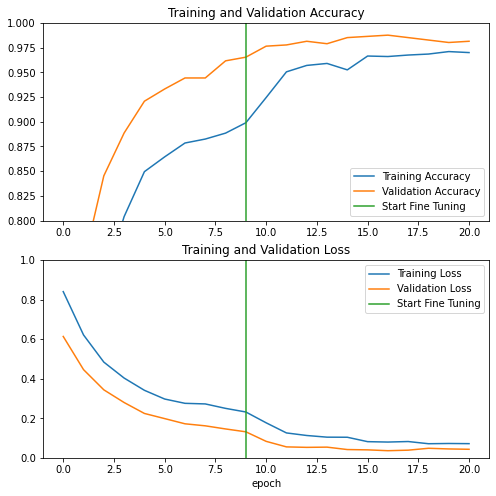

In [34]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

6/6 [==============================] - 0s 32ms/step - loss: 0.0132 - accuracy: 1.0000
Test accuracy : 1.0


Predictions:
 [0 0 0 0 1 0 1 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1]
Labels:
 [0 0 0 0 1 0 1 0 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1]


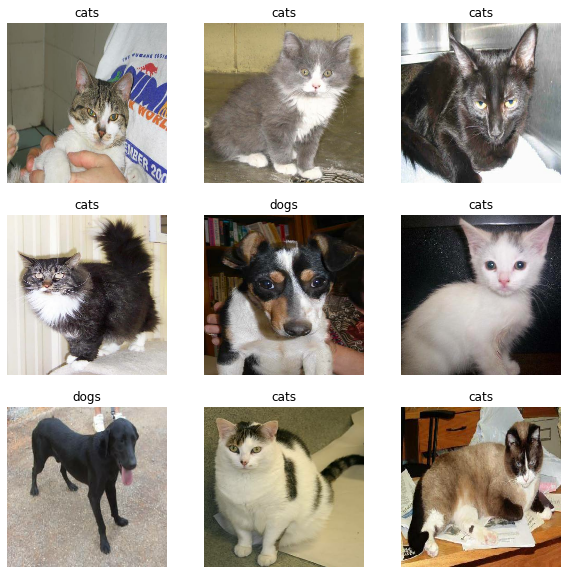

In [36]:
#Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")